In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import torch


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = "SPY.csv"
df = pd.read_csv(file_path)




# start to nov 2001 (dot com crash)
# not bad
df = df.iloc[:2228]

# nov 01 to june 2009
# not bad
# df = df.iloc[2228:4135]

# june 2009 to april 2020
# ass
# df = df.iloc[4135:6862]

# april 2020 to most recent
# ass
# df = df.iloc[6862:]


# Convert the "Date" column to datetime
# df["Date"] = pd.to_datetime(df["Date"], format='%Y/%m/%d')

# # Sort the data by date in ascending order
# df = df.sort_values(by="Date")

# # Get the earliest and latest dates
# earliest_date = df["Date"].min()
# latest_date = df["Date"].max()

# print("Earliest Date:", earliest_date)
# print("Latest Date:", latest_date)


In [4]:
print(df.tail())

            Date       Open       High        Low      Close    Volume  Day  \
2223  2001-11-23  74.380302  75.495615  74.354212  75.449959   6717100   23   
2224  2001-11-26  75.495635  75.880449  75.052119  75.613037  13726000   26   
2225  2001-11-27  75.410798  76.245651  74.412882  75.286873  19261400   27   
2226  2001-11-28  74.836875  75.117334  73.865054  73.923752  20195500   28   
2227  2001-11-29  74.132433  74.954239  73.701959  74.921631  16354700   29   

      Weekday  Week  Month  Year  
2223        4    47     11  2001  
2224        0    48     11  2001  
2225        1    48     11  2001  
2226        2    48     11  2001  
2227        3    48     11  2001  


In [5]:
# if 'Day' and 'Weekday' and 'Week' and 'Month' and 'Year' in df.columns:
    # df.drop(columns=['Day', 'Weekday', 'Week', 'Month', 'Year'], inplace=True)

In [6]:
if "Target" not in df.columns:
    # df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
    df["Target"] = df["Close"].shift(-1)


In [7]:
df = df.dropna()

In [8]:
# Adding SMA as part of the feature test
short_term_period = 20
medium_term_period = 50
long_term_period = 200

# Compute the SMAs
df['SMA_20'] = df['Close'].rolling(window=short_term_period).mean()
df['SMA_50'] = df['Close'].rolling(window=medium_term_period).mean()
df['SMA_200'] = df['Close'].rolling(window=long_term_period).mean()

df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()  # Short-term EMA
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()  # Medium-term EMA
df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()  # Long-term EMA


In [9]:
df = df.dropna()

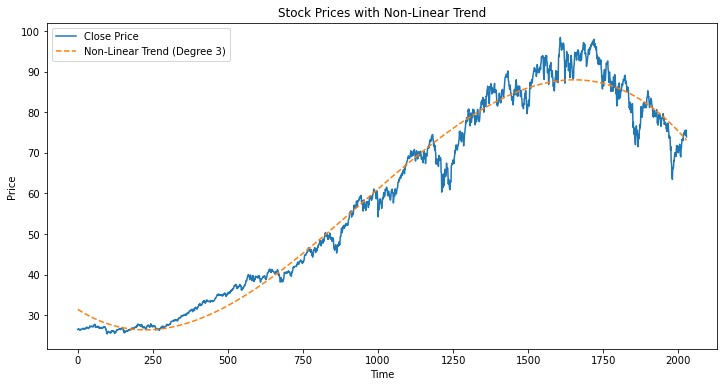

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Assuming you have a DataFrame `df` with a 'Close' column

# Create an index for the time series (usually the row number)
df['Time'] = np.arange(len(df))

# Fit a polynomial regression to the 'Close' price
X = df[['Time']]  # Independent variable (time)
y = df['Close']   # Dependent variable (closing price)

# Initialize a polynomial features transformer (degree = 2 for quadratic, or higher for more non-linearity)
degree = 3  # You can change the degree for more complexity
poly = PolynomialFeatures(degree)

# Transform the Time feature into polynomial features
X_poly = poly.fit_transform(X)

# Initialize and fit the linear regression model to the polynomial features
model = LinearRegression()
model.fit(X_poly, y)

# Generate predictions for the polynomial regression (non-linear trend)
df['Non_Linear_Trend'] = model.predict(X_poly)

# Optionally, visualize the non-linear trend
plt.figure(figsize=(12, 6))
plt.plot(df['Time'], df['Close'], label='Close Price')
plt.plot(df['Time'], df['Non_Linear_Trend'], label=f'Non-Linear Trend (Degree {degree})', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Prices with Non-Linear Trend')
plt.legend()
plt.show()

## CREATING THE NEURAL NETWORK MODEL

In [11]:
dates = df["Date"]
X = df.drop(columns=["Date", "Target"])
y = df["Target"]

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


In [13]:
# Define the LSTM-based model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)  # Output layer for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, input_size)
        out, _ = self.lstm(x)
        # Use the output of the last time step
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)
        out = self.fc(out)  # Shape: (batch_size, 1)
        out = self.sigmoid(out)
        return out

# Define a more complex LSTM-based model
# class ComplexLSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
#         super(ComplexLSTMModel, self).__init__()
#         # LSTM Layer: Bidirectional for richer context
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
#                             batch_first=True, dropout=dropout_rate,
#                             bidirectional=True)
#         # Fully connected layers for added complexity
#         self.fc1 = nn.Linear(hidden_size * 2, hidden_size)  # Bidirectional LSTM doubles hidden size
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.fc3 = nn.Linear(hidden_size // 2, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         # LSTM expects input of shape (batch_size, sequence_length, input_size)
#         out, _ = self.lstm(x)
#         # Use the output of the last time step
#         out = out[:, -1, :]  # Shape: (batch_size, hidden_size * 2)
#         out = self.fc1(out)  # First fully connected layer
#         out = self.dropout1(out)
#         out = torch.relu(out)  # Nonlinear activation
#         out = self.fc2(out)  # Second fully connected layer
#         out = self.dropout2(out)
#         out = torch.relu(out)  # Nonlinear activation
#         out = self.fc3(out)  # Output layer
#         out = self.sigmoid(out)  # Apply sigmoid for binary classification
#         return out

# class ComplexLSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
#         super(ComplexLSTMModel, self).__init__()
#         # LSTM Layer: Bidirectional for richer context
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
#                             batch_first=True, dropout=dropout_rate,
#                             bidirectional=True)
#         # Fully connected layers for added complexity
#         self.fc1 = nn.Linear(hidden_size * 2, hidden_size)  # Bidirectional LSTM doubles hidden size
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.fc3 = nn.Linear(hidden_size // 2, 1)

#     def forward(self, x):
#         # LSTM expects input of shape (batch_size, sequence_length, input_size)
#         out, _ = self.lstm(x)
#         # Use the output of the last time step
#         out = out[:, -1, :]  # Shape: (batch_size, hidden_size * 2)
#         out = self.fc1(out)  # First fully connected layer
#         out = self.dropout1(out)
#         out = torch.relu(out)  # Nonlinear activation
#         out = self.fc2(out)  # Second fully connected layer
#         out = self.dropout2(out)
#         out = torch.relu(out)  # Nonlinear activation
#         out = self.fc3(out)  # Output layer
#         return out

class ComplexLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(ComplexLSTMModel, self).__init__()
        # Unidirectional LSTM for sequential stock price prediction
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_rate)  # Removed bidirectional=True

        # Fully connected layers for added complexity
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size // 4, 1)

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, input_size)
        out, _ = self.lstm(x)
        # Use the output of the last time step
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)

        out = torch.relu(self.fc1(out))  # First fully connected layer
        out = self.dropout1(out)
        out = torch.relu(self.fc2(out))  # Second fully connected layer
        out = self.dropout2(out)
        out = self.fc3(out)  # Output layer (no activation for regression)
        return out


In [14]:

sequence_length = 10

# Reshape data into sequences
def create_sequences(data, target, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)


In [15]:

# scaler = StandardScaler()
# scaler = MinMaxScaler()
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "Day", "Weekday", "Week", "Month", "Year"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_20", "SMA_50", "SMA_200", "EMA_10", "EMA_50", "EMA_200", "Non_Linear_Trend"]
feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_20", "SMA_50", "SMA_200", "EMA_10", "EMA_50", "EMA_200"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "Non_Linear_Trend", "SMA_20", "SMA_50", "EMA_10", "EMA_50"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "Non_Linear_Trend"]

# Split data
train_size = int(X.shape[0] * 0.7)
val_size = int(X.shape[0] * 0.15)

# Initialize scaler
# scaler = RobustScaler()
scaler = MinMaxScaler()

# Split data into train, validation, and test
temp_train = X[:train_size]
temp_val = X[train_size:train_size + val_size]
temp_test = X[train_size + val_size:]

temp_train = temp_train[feature_columns]
temp_val = temp_val[feature_columns]
temp_test = temp_test[feature_columns]

# Fit and transform for train, transform for validation and test
temp_train = scaler.fit_transform(temp_train)
temp_val = scaler.transform(temp_val)
temp_test = scaler.transform(temp_test)

# Convert NumPy arrays back to DataFrames
temp_train = pd.DataFrame(temp_train, columns=feature_columns)
temp_val = pd.DataFrame(temp_val, columns=feature_columns)
temp_test = pd.DataFrame(temp_test, columns=feature_columns)

# Concatenate the data
X_scaled = pd.concat([temp_train, temp_val, temp_test], axis=0)

# scaler = StandardScaler()

# scaler.fit(X_train)
# X_scaled = pd.DataFrame(scaler.fit_transform(X[feature_columns]), columns=feature_columns, index=X.index)

X_seq, y_seq = create_sequences(X_scaled, y.values, sequence_length)


# Split sequentially
X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]

# Print sizes to confirm
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 1419, Val: 304, Test: 295


In [16]:

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [17]:
# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 128
num_layers = 2
dropout_rate = 0.1
learning_rate = 0.0005
num_epochs = 500
patience = 30


# Initialize the LSTM model
# model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate)
model = ComplexLSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate)

model.to(device)

# Define loss and optimizer
# criterion = nn.BCELoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with early stopping
best_val_loss = float('inf')
early_stop_counter = 0

# if not os.path.exists("./models/best_lstm_model.pth"):
if not os.path.exists("./lstm_trials/lstm_after_gridsearch_new.pth"):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch = y_batch.unsqueeze(1)  # Match output shape
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_batch = y_batch.unsqueeze(1)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # torch.save(model.state_dict(), "./lstm_trials/lstm_after_gridsearch_new.pth")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"Early stopping counter: {early_stop_counter}/{patience}")
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

# Load the best model
# model.load_state_dict(torch.load("./lstm_trials/lstm_after_gridsearch_new.pth"))

# Evaluate on test data
model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

# Calculate Mean Absolute Error (MAE)
test_mae = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        mae = torch.mean(torch.abs(outputs - y_batch))
        test_mae += mae.item() * X_batch.size(0)

test_mae /= len(test_loader.dataset)
print(f'Test MAE: {test_mae:.4f}')


Epoch 1/500, Train Loss: 2565.4267, Val Loss: 8117.7435
Epoch 2/500, Train Loss: 2446.2009, Val Loss: 7649.3877
Epoch 3/500, Train Loss: 2134.6000, Val Loss: 6934.7046
Epoch 4/500, Train Loss: 1739.4360, Val Loss: 5956.0557
Epoch 5/500, Train Loss: 1263.5429, Val Loss: 4776.1554
Epoch 6/500, Train Loss: 818.0032, Val Loss: 3459.0876
Epoch 7/500, Train Loss: 490.4450, Val Loss: 2166.3900
Epoch 8/500, Train Loss: 380.9289, Val Loss: 1876.7604
Epoch 9/500, Train Loss: 375.2416, Val Loss: 1958.2745
Early stopping counter: 1/30
Epoch 10/500, Train Loss: 357.2389, Val Loss: 1884.2625
Early stopping counter: 2/30
Epoch 11/500, Train Loss: 193.3593, Val Loss: 1026.9008
Epoch 12/500, Train Loss: 81.6658, Val Loss: 278.9887
Epoch 13/500, Train Loss: 47.3894, Val Loss: 73.9166
Epoch 14/500, Train Loss: 44.5441, Val Loss: 46.8712
Epoch 15/500, Train Loss: 46.3825, Val Loss: 43.6576
Epoch 16/500, Train Loss: 47.1413, Val Loss: 47.8880
Early stopping counter: 1/30
Epoch 17/500, Train Loss: 46.4528, 

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [18]:
# X_seq_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
# y_seq_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# outputs = model(X_seq_tensor)

# error = 0
# largest_error = 0
# less_than_actual = 0
# more_than_actual = 0

# for true, pred in zip(y_test, outputs):
#     percent = abs(true - pred) / true
#     if percent > largest_error:
#         largest_error = percent
#     error += percent
#     if pred < true:
#         less_than_actual += 1
#     else:
#         more_than_actual += 1

# error = error / len(y_test)
# error = error.item()
# largest_error = largest_error.item()
# print(f"Average error percentage: {error*100}")
# print(f"Largest error percentage: {largest_error*100}")
# print(f"Less than actual: {less_than_actual}")
# print(f"More than actual: {more_than_actual}")



In [19]:

# plt.figure(figsize=(12, 6))
# plt.plot(y_test, label='True Values')
# plt.plot(outputs.cpu().detach().numpy(), label='Predicted Values')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('True vs Predicted Values')
# plt.legend()
# plt.show()

## Evaluating on entire dataset

In [20]:
# X_seq_tensor = torch.tensor(X_seq, dtype=torch.float32).to(device)
# y_seq_tensor = torch.tensor(y_seq, dtype=torch.float32).to(device)

# outputs = model(X_seq_tensor)


In [21]:
# error = 0
# largest_error = 0
# less_than_actual = 0
# more_than_actual = 0

# for true, pred in zip(y_seq, outputs):
#     percent = abs(true - pred) / true
#     if percent > largest_error:
#         largest_error = percent
#     error += percent
#     if pred < true:
#         less_than_actual += 1
#     else:
#         more_than_actual += 1

# error = error / len(y_seq)
# error = error.item()
# largest_error = largest_error.item()
# print(f"Average error percentage: {error*100}")
# print(f"Largest error percentage: {largest_error*100}")
# print(f"Less than actual: {less_than_actual}")
# print(f"More than actual: {more_than_actual}")


In [22]:
# train_cutoff = int(len(y_seq) * 0.7)
# val_cutoff = int(len(y_seq) * 0.85)

# plt.figure(figsize=(12, 6))
# plt.plot(y_seq, label='True Values')
# plt.plot(outputs.cpu().detach().numpy(), label='Predicted Values')
# plt.axvline(x=train_cutoff, color='g', linestyle='--', label='Train/Val Split (80%)')
# plt.axvline(x=val_cutoff, color='b', linestyle='--', label='Val/Test Split (90%)')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('True vs Predicted Values')
# plt.legend()
# plt.show()

In [23]:
# outputs

In [24]:
# df['Target_Higher_Lower'] = np.where(df['Target'] > df['Open'], 'higher', 'lower')

In [25]:
# # Ensure outputs is detached from the computation graph and converted to numpy
# predicted_values = outputs.cpu().detach().numpy()

# # Add the predicted values as a new column in the dataframe
# df['Predicted'] = np.nan
# df.loc[df.index[-len(predicted_values):], 'Predicted'] = predicted_values

# print(df[['Date', 'Target', 'Predicted']].tail())

In [26]:
new_df = df.dropna()

In [27]:
# new_df['Predicted_Higher_Lower'] = np.where(new_df['Predicted'] > new_df['Open'], 'higher', 'lower')
# new_df['Correct'] = np.where(new_df['Predicted_Higher_Lower'] == new_df['Target_Higher_Lower'], 1, 0)

# print('number of correct predictions:', new_df['Correct'].sum())


===== Trial 1 =====
Epoch 1/500, Train Loss: 2634.9911, Val Loss: 8136.9379
Epoch 2/500, Train Loss: 2388.8531, Val Loss: 7417.8015
Epoch 3/500, Train Loss: 1936.8925, Val Loss: 6127.9424
Epoch 4/500, Train Loss: 1243.9644, Val Loss: 4470.1360
Epoch 5/500, Train Loss: 648.2368, Val Loss: 2675.9438
Epoch 6/500, Train Loss: 378.8600, Val Loss: 1657.0274
Epoch 7/500, Train Loss: 363.9712, Val Loss: 1998.1639
Epoch 8/500, Train Loss: 356.5151, Val Loss: 1810.9233
Epoch 9/500, Train Loss: 258.9973, Val Loss: 1338.3125
Epoch 10/500, Train Loss: 82.5977, Val Loss: 306.6272
Epoch 11/500, Train Loss: 33.9135, Val Loss: 42.5053
Epoch 12/500, Train Loss: 33.0905, Val Loss: 91.1399
Epoch 13/500, Train Loss: 36.4137, Val Loss: 74.4979
Epoch 14/500, Train Loss: 36.6683, Val Loss: 58.2309
Epoch 15/500, Train Loss: 34.8724, Val Loss: 37.8554
Epoch 16/500, Train Loss: 31.9031, Val Loss: 39.7761
Epoch 17/500, Train Loss: 34.3690, Val Loss: 28.4763
Epoch 18/500, Train Loss: 34.4520, Val Loss: 27.3926
Ep

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/500, Train Loss: 2577.8732, Val Loss: 8125.5191
Epoch 2/500, Train Loss: 2401.0619, Val Loss: 7469.6029
Epoch 3/500, Train Loss: 1981.8513, Val Loss: 6389.6438
Epoch 4/500, Train Loss: 1407.3003, Val Loss: 4916.2642
Epoch 5/500, Train Loss: 806.5488, Val Loss: 3215.7113
Epoch 6/500, Train Loss: 428.0442, Val Loss: 1706.4695
Epoch 7/500, Train Loss: 389.3404, Val Loss: 2080.9827
Epoch 8/500, Train Loss: 377.2741, Val Loss: 1800.8290
Epoch 9/500, Train Loss: 334.6506, Val Loss: 1634.4639
Epoch 10/500, Train Loss: 118.4732, Val Loss: 584.7201
Epoch 11/500, Train Loss: 43.8638, Val Loss: 93.5523
Epoch 12/500, Train Loss: 45.4416, Val Loss: 61.9910
Epoch 13/500, Train Loss: 38.9815, Val Loss: 51.1546
Epoch 14/500, Train Loss: 36.2216, Val Loss: 47.1117
Epoch 15/500, Train Loss: 37.5183, Val Loss: 37.8286
Epoch 16/500, Train Loss: 30.1987, Val Loss: 33.6924
Epoch 17/500, Train Loss: 35.7420, Val Loss: 20.4473
Epoch 18/500, Train Loss: 32.2525, Val Loss: 31.1577
Epoch 19/500, Train Lo

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/500, Train Loss: 2621.2705, Val Loss: 8194.4431
Epoch 2/500, Train Loss: 2554.2473, Val Loss: 7881.6759
Epoch 3/500, Train Loss: 2291.8776, Val Loss: 7361.8196
Epoch 4/500, Train Loss: 1971.4430, Val Loss: 6641.3740
Epoch 5/500, Train Loss: 1635.2860, Val Loss: 5740.5814
Epoch 6/500, Train Loss: 1183.6471, Val Loss: 4560.4557
Epoch 7/500, Train Loss: 760.0684, Val Loss: 3239.6252
Epoch 8/500, Train Loss: 441.0404, Val Loss: 1957.7826
Epoch 9/500, Train Loss: 433.3172, Val Loss: 1974.2859
Epoch 10/500, Train Loss: 383.8655, Val Loss: 1825.2724
Epoch 11/500, Train Loss: 186.9778, Val Loss: 965.2894
Epoch 12/500, Train Loss: 84.4987, Val Loss: 329.1453
Epoch 13/500, Train Loss: 60.3451, Val Loss: 116.5751
Epoch 14/500, Train Loss: 51.2155, Val Loss: 92.8636
Epoch 15/500, Train Loss: 60.5066, Val Loss: 78.0567
Epoch 16/500, Train Loss: 60.5442, Val Loss: 56.3135
Epoch 17/500, Train Loss: 50.5909, Val Loss: 38.1231
Epoch 18/500, Train Loss: 50.6028, Val Loss: 53.0486
Epoch 19/500, T

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/500, Train Loss: 2585.9052, Val Loss: 8092.7656
Epoch 2/500, Train Loss: 2419.8807, Val Loss: 7482.2755
Epoch 3/500, Train Loss: 2007.8138, Val Loss: 6543.9389
Epoch 4/500, Train Loss: 1519.2608, Val Loss: 5283.7880
Epoch 5/500, Train Loss: 944.9543, Val Loss: 3677.6843
Epoch 6/500, Train Loss: 473.2008, Val Loss: 1985.8172
Epoch 7/500, Train Loss: 386.3633, Val Loss: 1888.4011
Epoch 8/500, Train Loss: 372.2678, Val Loss: 1952.2119
Epoch 9/500, Train Loss: 370.5864, Val Loss: 1905.7086
Epoch 10/500, Train Loss: 330.6159, Val Loss: 1641.6719
Epoch 11/500, Train Loss: 112.9346, Val Loss: 492.1155
Epoch 12/500, Train Loss: 46.1541, Val Loss: 173.9425
Epoch 13/500, Train Loss: 36.7643, Val Loss: 109.7564
Epoch 14/500, Train Loss: 32.2611, Val Loss: 24.2655
Epoch 15/500, Train Loss: 32.6783, Val Loss: 19.9783
Epoch 16/500, Train Loss: 29.9309, Val Loss: 14.6873
Epoch 17/500, Train Loss: 33.7764, Val Loss: 16.8673
Epoch 18/500, Train Loss: 35.3157, Val Loss: 15.4984
Epoch 19/500, Tra

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/500, Train Loss: 2644.6931, Val Loss: 7997.6902
Epoch 2/500, Train Loss: 2313.4805, Val Loss: 7229.3395
Epoch 3/500, Train Loss: 1856.8244, Val Loss: 6018.7152
Epoch 4/500, Train Loss: 1207.5328, Val Loss: 4427.0140
Epoch 5/500, Train Loss: 647.0557, Val Loss: 2671.5598
Epoch 6/500, Train Loss: 387.3446, Val Loss: 1673.5911
Epoch 7/500, Train Loss: 365.9452, Val Loss: 1891.2612
Epoch 8/500, Train Loss: 375.1610, Val Loss: 1923.3287
Epoch 9/500, Train Loss: 262.8486, Val Loss: 1292.2867
Epoch 10/500, Train Loss: 73.2001, Val Loss: 279.0913
Epoch 11/500, Train Loss: 35.7679, Val Loss: 72.3241
Epoch 12/500, Train Loss: 31.6338, Val Loss: 35.4719
Epoch 13/500, Train Loss: 36.7248, Val Loss: 91.1027
Epoch 14/500, Train Loss: 32.0484, Val Loss: 71.3721
Epoch 15/500, Train Loss: 33.5135, Val Loss: 29.6477
Epoch 16/500, Train Loss: 31.3188, Val Loss: 34.1818
Epoch 17/500, Train Loss: 32.2156, Val Loss: 48.3839
Epoch 18/500, Train Loss: 32.7445, Val Loss: 24.4087
Epoch 19/500, Train Los

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/500, Train Loss: 2605.6215, Val Loss: 8086.5029
Epoch 2/500, Train Loss: 2379.3516, Val Loss: 7477.6148
Epoch 3/500, Train Loss: 2039.7450, Val Loss: 6571.2104
Epoch 4/500, Train Loss: 1534.3725, Val Loss: 5380.3788
Epoch 5/500, Train Loss: 1009.8893, Val Loss: 3978.4113
Epoch 6/500, Train Loss: 560.6908, Val Loss: 2500.6010
Epoch 7/500, Train Loss: 376.9829, Val Loss: 1745.5943
Epoch 8/500, Train Loss: 397.1233, Val Loss: 2144.1674
Epoch 9/500, Train Loss: 366.8669, Val Loss: 1811.2275
Epoch 10/500, Train Loss: 301.2370, Val Loss: 1616.2447
Epoch 11/500, Train Loss: 131.4808, Val Loss: 634.5035
Epoch 12/500, Train Loss: 46.6811, Val Loss: 109.5557
Epoch 13/500, Train Loss: 40.7057, Val Loss: 86.3977
Epoch 14/500, Train Loss: 45.6719, Val Loss: 36.5833
Epoch 15/500, Train Loss: 38.2261, Val Loss: 58.8914
Epoch 16/500, Train Loss: 42.3067, Val Loss: 54.5913
Epoch 17/500, Train Loss: 42.5514, Val Loss: 27.3236
Epoch 18/500, Train Loss: 43.6847, Val Loss: 75.1195
Epoch 19/500, Tra

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/500, Train Loss: 2600.4935, Val Loss: 8059.1477
Epoch 2/500, Train Loss: 2370.6958, Val Loss: 7368.5241
Epoch 3/500, Train Loss: 1962.2109, Val Loss: 6242.3283
Epoch 4/500, Train Loss: 1341.3029, Val Loss: 4741.9346
Epoch 5/500, Train Loss: 737.5327, Val Loss: 3015.6936
Epoch 6/500, Train Loss: 397.1210, Val Loss: 1685.5223
Epoch 7/500, Train Loss: 375.5998, Val Loss: 2015.6219
Epoch 8/500, Train Loss: 328.4979, Val Loss: 1743.3288
Epoch 9/500, Train Loss: 135.6118, Val Loss: 642.6127
Epoch 10/500, Train Loss: 44.7676, Val Loss: 76.6105
Epoch 11/500, Train Loss: 34.1709, Val Loss: 57.8002
Epoch 12/500, Train Loss: 34.1944, Val Loss: 32.7439
Epoch 13/500, Train Loss: 31.8568, Val Loss: 14.7118
Epoch 14/500, Train Loss: 34.3076, Val Loss: 47.4277
Epoch 15/500, Train Loss: 29.1876, Val Loss: 31.6486
Epoch 16/500, Train Loss: 32.7910, Val Loss: 39.2844
Epoch 17/500, Train Loss: 32.1041, Val Loss: 36.2202
Epoch 18/500, Train Loss: 32.6885, Val Loss: 41.6952
Epoch 19/500, Train Loss:

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/500, Train Loss: 2599.4315, Val Loss: 8095.2848
Epoch 2/500, Train Loss: 2405.2200, Val Loss: 7568.9698
Epoch 3/500, Train Loss: 2076.0867, Val Loss: 6716.1055
Epoch 4/500, Train Loss: 1603.7472, Val Loss: 5481.7568
Epoch 5/500, Train Loss: 1049.2200, Val Loss: 4009.1625
Epoch 6/500, Train Loss: 566.0767, Val Loss: 2450.7345
Epoch 7/500, Train Loss: 377.2334, Val Loss: 1736.9946
Epoch 8/500, Train Loss: 374.4872, Val Loss: 1888.0277
Epoch 9/500, Train Loss: 326.0713, Val Loss: 1592.8053
Epoch 10/500, Train Loss: 117.5439, Val Loss: 591.5854
Epoch 11/500, Train Loss: 49.3651, Val Loss: 143.0760
Epoch 12/500, Train Loss: 42.4843, Val Loss: 62.7358
Epoch 13/500, Train Loss: 34.6140, Val Loss: 78.4909
Epoch 14/500, Train Loss: 38.5309, Val Loss: 64.2968
Epoch 15/500, Train Loss: 42.2076, Val Loss: 62.2126
Epoch 16/500, Train Loss: 39.6946, Val Loss: 52.1824
Epoch 17/500, Train Loss: 36.4246, Val Loss: 61.2142
Epoch 18/500, Train Loss: 35.1974, Val Loss: 64.7731
Epoch 19/500, Train 

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/500, Train Loss: 2593.8923, Val Loss: 8062.1498
Epoch 2/500, Train Loss: 2347.4143, Val Loss: 7248.9348
Epoch 3/500, Train Loss: 1818.5256, Val Loss: 5907.8319
Epoch 4/500, Train Loss: 1133.1844, Val Loss: 4126.0666
Epoch 5/500, Train Loss: 554.8182, Val Loss: 2161.1238
Epoch 6/500, Train Loss: 359.7278, Val Loss: 1836.0619
Epoch 7/500, Train Loss: 366.4752, Val Loss: 1925.1146
Epoch 8/500, Train Loss: 365.0760, Val Loss: 1896.9853
Epoch 9/500, Train Loss: 216.2587, Val Loss: 1048.6207
Epoch 10/500, Train Loss: 55.0752, Val Loss: 140.0294
Epoch 11/500, Train Loss: 36.0945, Val Loss: 88.9336
Epoch 12/500, Train Loss: 30.6959, Val Loss: 71.1966
Epoch 13/500, Train Loss: 28.5524, Val Loss: 65.5233
Epoch 14/500, Train Loss: 28.2087, Val Loss: 67.9086
Epoch 15/500, Train Loss: 26.3921, Val Loss: 60.0596
Epoch 16/500, Train Loss: 24.4451, Val Loss: 24.6533
Epoch 17/500, Train Loss: 32.4069, Val Loss: 44.6370
Epoch 18/500, Train Loss: 26.4407, Val Loss: 31.6439
Epoch 19/500, Train Los

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


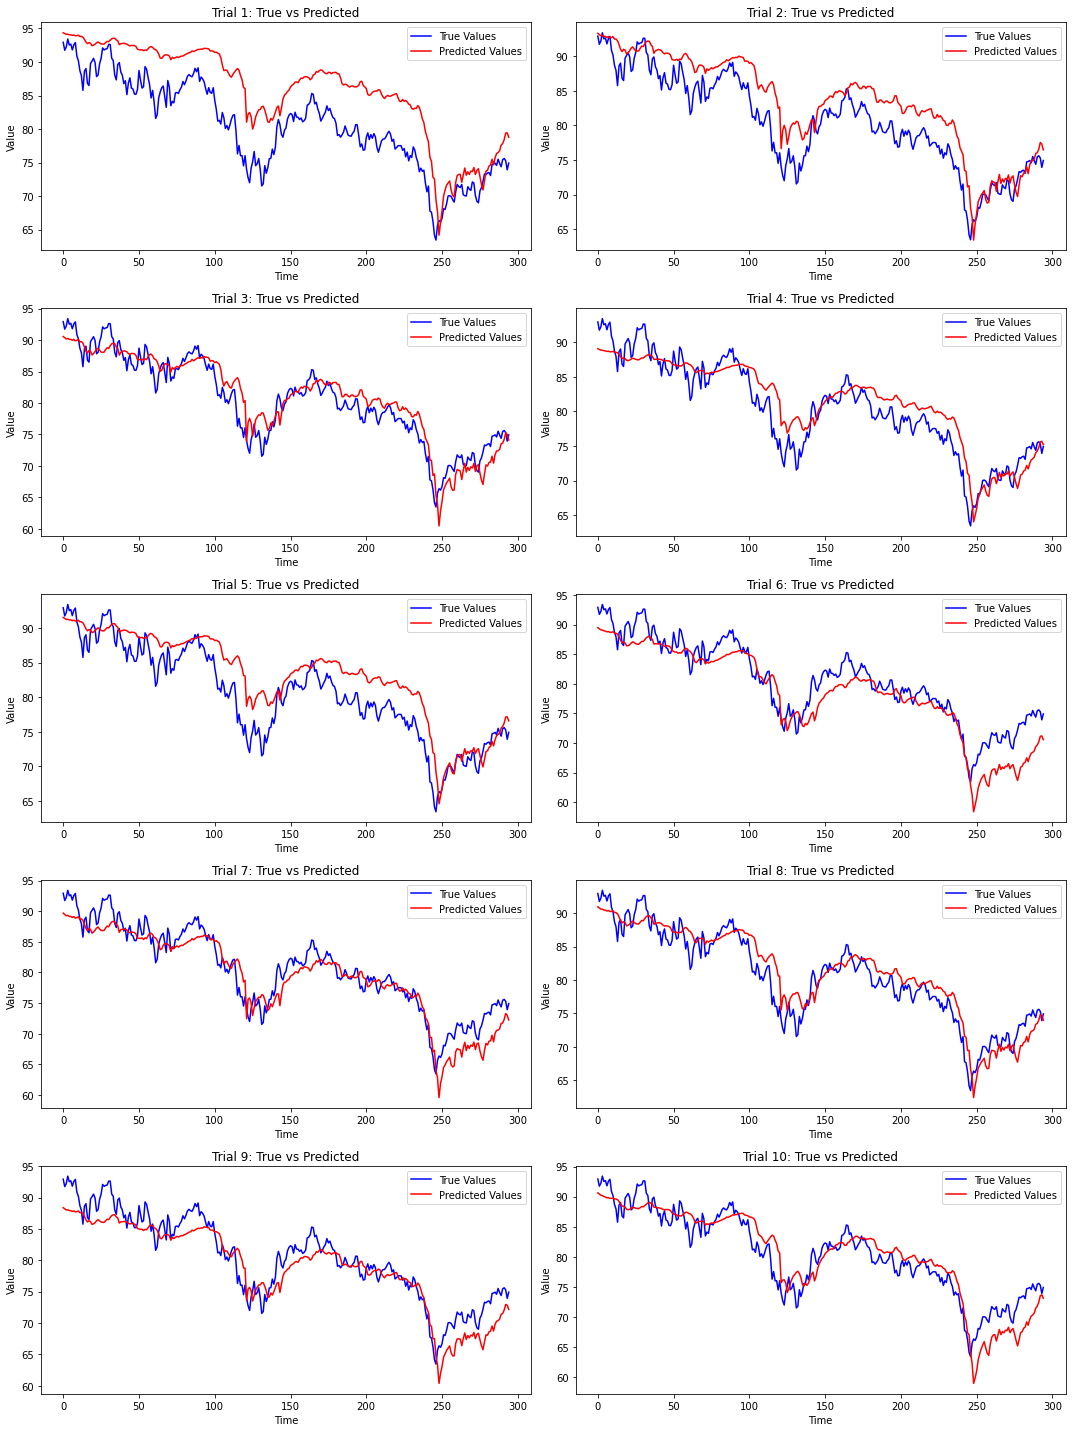


===== Final Results Across 10 Trials =====
Average Validation Loss: 16.8604 ± 7.2962
Average Test Loss: 32.1275 ± 8.7359
Average MAE: 4.2765 ± 0.6621
Average Error Percentage: 3.39% ± 1.19%
Largest Error Percentage: 11.61% ± 2.12%


In [28]:
# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 128
num_layers = 2
dropout_rate = 0.1
learning_rate = 0.0005
num_epochs = 500
patience = 30
num_trials = 10  # Number of runs

# Store results
results = {
    "val_loss": [],
    "test_loss": [],
    "mae": [],
    "avg_error_percent": [],
    "largest_error_percent": []
}

# Multi-plot setup
fig, axes = plt.subplots(5, 2, figsize=(15, 20))  # 5 rows, 2 columns

for trial in range(num_trials):
    print(f"\n===== Trial {trial+1} =====")
    
    # Initialize model
    model = ComplexLSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate).to(device)

    # Define loss and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop with early stopping
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch = y_batch.unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_batch = y_batch.unsqueeze(1)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

    # Evaluate on test data
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_batch.size(0)

    test_loss /= len(test_loader.dataset)

    # Calculate Mean Absolute Error (MAE)
    test_mae = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            mae = torch.mean(torch.abs(outputs - y_batch))
            test_mae += mae.item() * X_batch.size(0)

    test_mae /= len(test_loader.dataset)

    # Compute error percentages
    X_seq_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_seq_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
    outputs = model(X_seq_tensor).cpu().detach().numpy()

    error = 0
    largest_error = 0
    less_than_actual = 0
    more_than_actual = 0

    for true, pred in zip(y_test, outputs):
        percent = abs(true - pred) / true
        if percent > largest_error:
            largest_error = percent
        error += percent
        if pred < true:
            less_than_actual += 1
        else:
            more_than_actual += 1

    avg_error = (error / len(y_test)).item()
    largest_error = largest_error.item()

    # Store results
    results["val_loss"].append(val_loss)
    results["test_loss"].append(test_loss)
    results["mae"].append(test_mae)
    results["avg_error_percent"].append(avg_error * 100)
    results["largest_error_percent"].append(largest_error * 100)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Average error percentage: {avg_error * 100:.2f}%")
    print(f"Largest error percentage: {largest_error * 100:.2f}%")

    # Plot predictions
    ax = axes[trial // 2, trial % 2]
    ax.plot(y_test, label='True Values', color='blue')
    ax.plot(outputs, label='Predicted Values', color='red')
    ax.set_title(f'Trial {trial + 1}: True vs Predicted')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.legend()

# Display all subplots
plt.tight_layout()
plt.show()

# Print final average results
print("\n===== Final Results Across 10 Trials =====")
print(f"Average Validation Loss: {np.mean(results['val_loss']):.4f} ± {np.std(results['val_loss']):.4f}")
print(f"Average Test Loss: {np.mean(results['test_loss']):.4f} ± {np.std(results['test_loss']):.4f}")
print(f"Average MAE: {np.mean(results['mae']):.4f} ± {np.std(results['mae']):.4f}")
print(f"Average Error Percentage: {np.mean(results['avg_error_percent']):.2f}% ± {np.std(results['avg_error_percent']):.2f}%")
print(f"Largest Error Percentage: {np.mean(results['largest_error_percent']):.2f}% ± {np.std(results['largest_error_percent']):.2f}%")
